**INSTRUCTIONS:** Just click on a cell (starting from the top one) and press the play button (single triangle) above. Then wait for the cell to finish (a number appears), and then do the one below. You only need to look at 'Explanation' and 'Display', but you need to run all cells.

In [43]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import pickle
import numpy as np
import os

# Explanation


**Changes Summary**:

For details, see below.

- Ideological orientation: is now a continuous scale, with liberal being positive values and conservative negative values. The starting population is drawn from a normal distribution with a mean and sd that we can set.
- Researcher populations: there are now candidate researchers and tenured researchers. When a tenured researcher retires, they are replaced by a candidate researcher. Both publish papers, but only candidates self censure. They retire at different ages.
- Hiring dynamics: Candidates replace retiring tenured researchers on the basis of the mean ideology of tenured resaerchers and number of accepted ideas.

**Model parameters:**


- N: Number of tenured and candidate researchers in the starting pool. The number of tenured is N, the number of candidates is 2*N.
- num_ideas: number of ideas in the starting pool.
- mean_ideology: the mean ideology of initialized researchers and initialized ideological ideas
- sd_ideology: Standard deviation of the distribution from which starting ideologies are sampled. The larger this is, the more variation in these.
- error: proportion of false positives and false negatives in peer review without ideological bias
- p_false_positive: increase in proportion in false positives due to ideological bias
- p_false_negative: increase in proportion in false negatives due to ideological bias
- p_true_start: proportion of true ideas in the starting population of ideas
- p_new_idea: probability in any given step of each researcher to launch a new idea 
- p_new_idea_true: probability that a newly launched idea is true
- p_ideology_idea: probability that a newly launched idea is ideological. If it is not ideological, it has ideology 0 and is neutral.
- promotion_weight_ideology: Candidates are selected for promotion on the basis of their ideology (in line with dominant or not) and number of papers published. This number (a value between 0 and 1) determines the weight of ideology. If set to 0, ideology does not play a role, if set to 1 the number of papers doesn't play a role.
- p_ideology_reviewer: modifies how likely it is that you get a reviewer with the same ideology as the idea
- censure: true or false for whether candidates from the minority ideology refrain from publishing ideological ideas. If True, to only publish neutral ideas.
- sd_ideas: How much the orientation of a newly launched ideological idea can be different from that of its originator.


**The model has the following assumptions about researchers:**

*Two populations & population composition:*
- There is a population of candidate researchers and a population of tenured researchers.
- At initialization, the candidate researchers are between 23 and 35, and the tenured researchers are between 25 and 65.
- Candidate researchers retire at 65, candidate researchers retire at 35.
- The pool of candidate researchers is twice as big as that of tenured researchers.
- When tenured researchers retire, they are replaced by a candidate researcher who then gets promoted. This candiate then gets replaced by a new candidate researcher. Thus, the total number of researchers always remains the same.
- Candidates are promoted for selection on the basis of the number of accepted ideas they launched over the previous 10 ticks of the model and on the basis of their ideology. If their ideology is in line with the mean ideology, they get a boost in their chances to get hired, while if it is not they get a punishment. The parameter 'promotion_weight_ideology' determines the weight of ideology in the promotion decision. If it is set at 0, the decision is made entirely on the basis of number of papers. A higher value (between 0 and 1) gives more weight to ideology. Note: we could change this dynamic, and instead of letting the mean ideology determine the punishment/boost, we could let the ideology of the retiring researcher do that. Maybe this is more realistic?
- Retiring candidates and promoted candidates are replaced by new candidates with an orientation randomly sampled from a normal distribution with mean 0 and sd 'sd_ideology'. In other words, their orientation is independent from the current mean or from the person they are replacing.

*Idealogical Orientation:*
- Each researcher has an ideological orientation which is on a continuous scale around 0 (neutral). Positive numbers are liberal, and negative numbers are conservative. 
- The ideology of the starting population of researchers is sampled from a normal distribution with mean 'mean_ideology' and standard deviation 'sd_ideology'. This is supposed to reflect the 1950s. Note: we could change this distribution on the basis of what we know about the 50ies. Is more of the mass towards the mean, or does it have longer tails? Is the distribution skewed? etc.


*Launching and reviewing ideas:*
- Every six months, each researcher launches a new idea with a probability of p_new_idea (currently 0.8)
- This idea has a probability of being true of p_new_idea_true (currently 0.5)
- This idea is either neutral or ideological, and this proportion is determined by 'p_ideology_idea'. If it is ideological, its orientation is sampled from a normal distribution with the orientation of the researcher set as the mean and the standard deviation 'sd_ideas'. 
- This idea is reviewed by two random other researchers from the population, and only added to the population of ideas if both reviewers think the idea is true.
- If the 'censure' parameter is set to True, candidate_researchers who have an orientation that is not in line with the mean orientation will only launch neutral ideas.

**The model has the following assumptions about ideas:**

- All ideas have an idealogical orientation on the same continuous scale as the researchers.
- The initial ideas are either neutral (ideology 0) or ideological, and the proportion is managed by p_ideology_idea. The ideological ideas are sampled from the same normal distribution as the researchers. While new ideas have a probability of being ideological of p_ideology_idea, the initial population has p_ideology_idea / 4. This is to artificially set up that the share of ideological ideas has increased compared to 70 years ago. Note: unsure whether we should do this.
- All ideas are either true or false. The proportion of true ideas in the initial population is p_true_start.
- Each step, we randomly remove the same number of ideas that is added after review. This way, the population of ideas remains the same.

**The model has the following assumptions about peer review:**

- Each newly launched idea is reviewed by two random researchers, and only admitted to the population if it gets considered True by each reviewer.
- Reviewers have basic false positive and false negative raters set by error.
- If a reviewer reviews a paper with their own ideological orientation (liberal reviewing liberal or conservative reviewing conservative -- no effect for neutral ideas or resaerchers), their false positive and false negative rates change:
    - If the ideology of idea and reviewer is the same, the false positive rate (false papers being considered true) increases by p_false_positive.
    - If the ideology of idea and reviewer is different, the false negative rate (true papers being considered false) increases by p_false_negative
- If an idea is ideological, it has an increased probability of getting reviewer with the same orientation. More precisely, there is a certain probability, expressed by parameter 'p_ideology_reviewer', that instead of choosing random reviewers we randomly select 10% of the population and take the two reviewers with the ideology most in line with that of the idea. Note: This is pretty random, so we should think about how precisely we want to do this.

**Questions:**

- The interactive plots have varying variables for all parameters. Which parameters can we keep fixed? I think there are two criteria:
    - Parameters that we know empirically (e.g. values from the 1950ies)
    - Parameters that we are not really interested in, and that don't really have interesting effects such as interactions with other parameters or an effect on ideology. For example, I imagine that changing 'error' just makes more or less ideas false, but doesn't really change any of the model dynamics.
    
- Given the hiring dynamics we've put in (the mean orientation of the population plays a role in selecting candidates to replace retiring researchers) it is not surprising that whenever we run the model, one orientation just ends up dominating rather quickly. If the starting mean orientation is positive, everyone ends up liberal in the end, and vice versa for conservative (and if it is 0, the direction is random depending on noise but also ends in one extreme). Depending on how high the standard deviation of ideological ideas and hiring is, the mean orientation stabilizes after a while when all researchers in the population have the same orientation. *Does this mean we have to change the model dynamics? More precisely, should we use a different mechanism than rewarding candidates for having the same orientation as the mean of the population (and punishing people for the reverse)? We could, for example, check more rigorously if just the effect of ideological bias in peer review is enough to result in liberal domination.* 
    
- The model has become very complex, and outcomes and dynamics depend on parameters for which we cannot really know the true value, such as p_false_positive (the extent to which ideology leads to false positive judgements) or p_ideology_idea (the proportion of ideas that are ideological). *Has the model become too complex to really do anything with it?* Originally we wanted to compare to how science really evolved, but this would require tuning so many unknown parameters that it is not clear that this is meaningful. The other aim we had was to confirm that the dynamics we had in mind really lead to a dominating ideology and more false ideas, and this does indeed seem to be the case. But again, it depends a bit on choosing parameters, and it is maybe not so surprising given the hiring dynamic we chose (using the mean orientation of the population). 

- One further way of makig the model more complex is by adding an epistemic landscape of ideas, part of which is ideological, and investigating how different dynamics mean that different parts of this landscape do or do not get explored. I imagine the outcome of this would just be that the part of the landscape that is more open to the minority opinion would not get explored, so maybe not so interesting. Worth looking into this?

- The total number of ideas and resaerchers is kept stable: for each resaercher that retires, another one is hired, and for each idea that is accepted, another one disappears. This keeps the size of the model manageable, but it makes it a bit less realistic. Is that a problem?

- Should we sample orientations from another distribution than the normal? There must be empirical data about this, maybe people tend to reside in clusters with some variation within these clusters? A micture of gaussian distributions could work for this (see below).

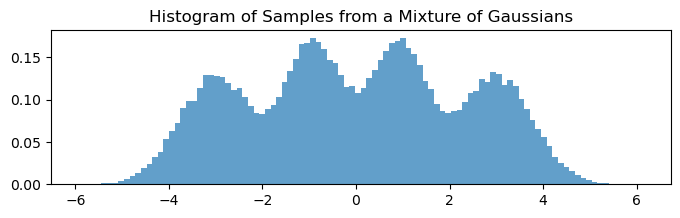

In [22]:
# Parameters for the mixture components
means = [-3,-1,0, 1,3]
variances = [0.6, 0.3, 0.5,0.3,0.6]
weights = [0.25,0.2,0.1,0.2,0.25]  # Equal weights
n_samples = 100000

# Generate samples from each component
samples = np.concatenate([
    np.random.normal(mu, np.sqrt(sigma), int(w*n_samples))
    for mu, sigma, w in zip(means, variances, weights)
])
plt.figure(figsize=(8, 2))  # 10 inches wide by 6 inches tall

# Plotting the samples
plt.hist(samples, bins=100, alpha=0.7, density=True)
plt.title('Histogram of Samples from a Mixture of Gaussians')
plt.show()

# Batch run data

In [17]:
# batch run values

n_vals = 2

N = 700
num_ideas = 700
n_ticks = 120# number of half years the model should run




variable_params = {'N' : N, 
                   'num_ideas' : num_ideas ,
                   'mean_ideology' : [0.05,0.5] ,
                   'error' : [0.1,0.3] ,
                   'p_false_positive' : np.linspace(0.05, 0.8, n_vals) ,
                   'p_false_negative' : np.linspace(0.05, 0.8, n_vals) ,
                   'p_true_start' : 0.9, 
                   'p_new_idea' : [0.3,0.7],
                   'p_new_idea_true' : [0.3,0.7],
                   'p_ideology_idea' : np.linspace(0.1, 0.8, n_vals),
                   'sd_ideology': [0.2,1],
                   'promotion_weight_ideology' : [0.3,0.7],
                   'p_ideology_reviewer' : np.linspace(0.1,0.8, n_vals),
                  'censure': [True,False],
                  'sd_ideas' : [0.2,1] 
}

In [42]:
# batch run data
# have to recombine the 25mb chunks into a single file due to github size limits


def recombine_parts(parts, output_file_path):
    """Recombine parts back into a single file, checking the integrity of each part."""
    with open(output_file_path, 'wb') as output_file:
        for part_file_path in parts:
            if not os.path.exists(part_file_path):
                print(f"Missing part: {part_file_path}")
                continue
            with open(part_file_path, 'rb') as part_file:
                part_data = part_file.read()
                if not part_data:
                    print(f"No data could be read from {part_file_path}")
                output_file.write(part_data)
                print(f'Part {part_file_path} added, size {len(part_data)} bytes.')
    print('All parts have been recombined.')
    
parts = ['part_0.pkl',
 'part_1.pkl',
 'part_2.pkl',
 'part_3.pkl',
 'part_4.pkl']

# # Example usage to recombine and then load the data
recombine_parts(parts, output_file_path='recombined.pkl')  # set num_parts correctly based on how many parts you have

# Load the original data object
with open('recombined.pkl', 'rb') as file:
    batch_run = pickle.load(file)

df = pd.DataFrame(batch_run)

Part part_0.pkl added, size 26214400 bytes.
Part part_1.pkl added, size 26214400 bytes.
Part part_2.pkl added, size 26214400 bytes.
Part part_3.pkl added, size 26214400 bytes.
Part part_4.pkl added, size 22517487 bytes.
All parts have been recombined.


# Plotting code

In [39]:
# Plotting functions

def preprocess_data(filtered_df):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df = filtered_df.copy()

    df['true_ideas'] = df[['True Ideas < -1', 'True Ideas -1 to 0', 'True Ideas 0 to 1', 'True Ideas > 1']].sum(axis=1)
    df['false_ideas'] = df[['False Ideas < -1', 'False Ideas -1 to 0', 'False Ideas 0 to 1', 'False Ideas > 1']].sum(axis=1)
    df['con'] = df['True Ideas -1 to 0'] + df['False Ideas -1 to 0']
    df['e_con'] = df['True Ideas < -1'] + df['False Ideas < -1']
    df['lib'] = df['True Ideas 0 to 1'] + df['False Ideas 0 to 1']
    df['e_lib'] = df['True Ideas > 1'] + df['False Ideas > 1']

    return df


def update_plots(p_false_positive, p_false_negative, p_ideology_idea, promotion_weight_ideology, p_ideology_reviewer,
                 censure, mean_ideology,error,p_new_idea,p_new_idea_true, sd_ideology,sd_ideas): #
    filtered_df = df[
        (df['p_false_positive'] == p_false_positive) &
        (df['p_false_negative'] == p_false_negative) &
        (df['p_ideology_idea'] == p_ideology_idea) &
        (df['promotion_weight_ideology'] == promotion_weight_ideology) &
        (df['p_ideology_reviewer'] == p_ideology_reviewer)  &
        (df['censure'] == censure) &
        (df['mean_ideology'] == mean_ideology) &
        (df['error'] == error) &
        (df['p_new_idea'] == p_new_idea) &
        (df['p_new_idea_true'] == p_new_idea_true) &
        (df['sd_ideology'] == sd_ideology) &
        (df['sd_ideas'] == sd_ideas)
        
    ] #

    if filtered_df.empty:
        print("No data available for this combination of parameters.")
        return

    filtered_df = preprocess_data(filtered_df)
    n_ticks = len(filtered_df)  # Assuming the number of ticks is the length of the dataframe

    # Plotting as per your code with slight modifications for clarity and correctness
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flatten()

    
    axs[0].plot(filtered_df['Step'],filtered_df['Researchers < -1'], color = 'darkblue')
    axs[0].plot(filtered_df['Step'],filtered_df['Researchers -1 to 0'], color = 'lightblue')
    axs[0].plot(filtered_df['Step'],filtered_df['Researchers 0 to 1'], color = 'lightgreen')
    axs[0].plot(filtered_df['Step'],filtered_df['Researchers > 1'], color = 'darkgreen')
    axs[0].set_title('Number of researchers', fontsize = 15)
    

    
    # Number of ideas over time
    axs[1].plot(filtered_df['Step'], filtered_df['e_con'], label='Extreme conservative', color='darkblue')
    axs[1].plot(filtered_df['Step'], filtered_df['con'], label='Conservative', color='lightblue')
    axs[1].plot(filtered_df['Step'], filtered_df['lib'], label='Liberal', color='lightgreen')
    axs[1].plot(filtered_df['Step'], filtered_df['e_lib'], label='Extreme liberal', color='darkgreen')
    axs[1].plot(filtered_df['Step'], filtered_df['total neutral ideas'], label='Neutral', color='grey')
    axs[1].set_title('Number of Ideas', fontsize = 15)
    axs[1].legend()

    # Ideological orientation over time
    axs[2].plot(filtered_df['Step'], filtered_df['Mean Orientation Tenured'], label='Tenured Researchers', color='red')
    axs[2].plot(filtered_df['Step'], filtered_df['Mean Orientation Accepted Ideas'], label='Accepted Ideas', color='grey')
    axs[2].set_title('Mean Ideological Orientation', fontsize = 15)
    axs[2].legend()

    # Truth value of ideas
    axs[3].plot(filtered_df['Step'], filtered_df['False Ideas'], label='False Ideas', color='red')
    axs[3].plot(filtered_df['Step'], filtered_df['True Ideas'], label='True Ideas', color='green')
    axs[3].set_title('Truth Value', fontsize = 15)
    axs[3].legend()

    # True and False Ideas by Ideology
    axs[4].plot(filtered_df['Step'], filtered_df['True Ideas > 1'] + filtered_df['True Ideas 0 to 1'], label='True Liberal', color='green')
    axs[4].plot(filtered_df['Step'], filtered_df['False Ideas > 1'] + filtered_df['False Ideas 0 to 1'], label='False Liberal', color='green', linestyle=':')
    axs[4].plot(filtered_df['Step'], filtered_df['True Ideas < -1'] + filtered_df['True Ideas -1 to 0'], label='True Conservative', color='blue')
    axs[4].plot(filtered_df['Step'], filtered_df['False Ideas < -1'] + filtered_df['False Ideas -1 to 0'], label='False Conservative', color='blue', linestyle=':')
    axs[4].plot(filtered_df['Step'],filtered_df['total neutral ideas'] - filtered_df['total true neutral ideas'], label = 'False neutral ideas', color = 'grey', linestyle = ':')
    axs[4].plot(filtered_df['Step'],filtered_df['total true neutral ideas'], label = 'True neutral ideas', color = 'grey')
    axs[4].set_title('True and False Ideas by Ideology', fontsize = 15)
    axs[4].legend()
    



    # Proportion of Accepted Ideas
    axs[5].plot(filtered_df['Step'], filtered_df['Proportion Accepted'], label='Proportion of ideas', color='purple')
    axs[5].set_title('Proportion of Falsely Accepted and Rejected Ideas Over Time', fontsize = 15)
    axs[5].legend()

    plt.tight_layout()
    plt.show()




In [40]:
# plottig code
style = {'description_width': 'initial'}
slider_layout = widgets.Layout(width='350px')  # Adjust width as needed    
p_false_positive_slider = widgets.SelectionSlider(options=[(f"{x:.2f}", x) for x in np.linspace(0.05, 0.8, n_vals)], value=0.05, description='p_false_positive',style=style, layout = slider_layout)
p_false_negative_slider = widgets.SelectionSlider(options=[(f"{x:.2f}", x) for x in np.linspace(0.05, 0.8, n_vals)], value=0.05, description='p_false_negative',style=style, layout = slider_layout)
p_ideology_idea_slider = widgets.SelectionSlider(options=[(f"{x:.2f}", x) for x in np.linspace(0.1, 0.8, n_vals)], value=0.1, description='p_ideology_idea',style=style, layout = slider_layout)
promotion_weight_ideology_slider = widgets.SelectionSlider(options=[(f"{x:.1f}", x) for x in [0.3, 0.7]], value=0.3, description='Promotion Weight Ideology',style=style, layout = slider_layout)
p_ideology_reviewer_slider = widgets.SelectionSlider(options=[(f"{x:.2f}", x) for x in np.linspace(0.1, 0.8, n_vals)], value=0.1, description='p_ideology_reviewer',style=style, layout = slider_layout)
censure_toggle = widgets.ToggleButtons(options=[(str(x), x) for x in [True, False]], value=True, description='Censure')

mean_ideology_slider = widgets.SelectionSlider(options= [0.05,0.5] , value=0.05, description='mean_ideology',style=style, layout = slider_layout)
error_slider = widgets.SelectionSlider(options=[0.1,0.3] , value=0.1, description='error',style=style, layout = slider_layout)
p_new_idea_slider = widgets.SelectionSlider(options=[0.3,0.7], value=0.3, description='p_new_idea',style=style, layout = slider_layout)
p_new_idea_true_slider = widgets.SelectionSlider(options=[0.3,0.7], value=0.3, description='p_new_idea_true',style=style, layout = slider_layout)
sd_ideology_slider = widgets.SelectionSlider(options=[0.2,1], value=0.2, description='sd_ideology',style=style, layout = slider_layout)
sd_ideas_slider = widgets.SelectionSlider(options=[0.2,1], value=0.2, description='sd_ideas',style=style, layout = slider_layout)




ui = widgets.VBox([p_false_positive_slider, p_false_negative_slider, p_ideology_idea_slider, promotion_weight_ideology_slider, p_ideology_reviewer_slider,
                  mean_ideology_slider, error_slider, p_new_idea_slider, p_new_idea_true_slider, sd_ideology_slider ,sd_ideas_slider, censure_toggle]) #
out = widgets.interactive_output(update_plots, {'p_false_positive': p_false_positive_slider, 'p_false_negative': p_false_negative_slider, 'p_ideology_idea': p_ideology_idea_slider, 
                                                'promotion_weight_ideology': promotion_weight_ideology_slider,'p_ideology_reviewer': p_ideology_reviewer_slider, 
                                                 'mean_ideology':mean_ideology_slider, 'error':error_slider,
                                               'p_new_idea':p_new_idea_slider, 'p_new_idea_true':p_new_idea_true_slider, 'sd_ideology':sd_ideology_slider,
                                               'sd_ideas':sd_ideas_slider,'censure': censure_toggle}) #



# Display

Use the sliders and button (for censure) to shift between different values, and wait for the plots to change. The plots show the results of the model for the particular combination of parameter values that you have chosen in the sliders.

In [41]:
# display

display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1800x1200 with 6 Axes>', …